In [1]:
#describe each location with companies in side
import pandas as pd
import numpy as np
import os
import pygeohash as pgh
from math import *
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import random
import matplotlib.pyplot as plt
pjoin = os.path.join

In [6]:
#data load
datapath = '/Users/yefeichen/Database/location_recommender_system/'
cfile = ['dnb_pa.csv','dnb_sf.csv','dnb_sj.csv']
lfile = 'location_scorecard_190912.csv'
clfile = ['PA.csv','SF.csv','SJ.csv']
testfile = 'train_val_test_location_company_all.csv'

ind_city = 2

comp_feat = pd.read_csv('company_feat.csv',index_col=0)
all_pair = pd.read_csv(testfile)
all_pair = all_pair[all_pair['city']==ind_city]
all_pair_test = all_pair[all_pair['fold']==2]
all_test_company = all_pair_test[['duns_number','groundtruth']].groupby(['duns_number','groundtruth'])[['duns_number','groundtruth']].first().reset_index(drop=True)
all_company_loc = pd.read_csv(pjoin(datapath,clfile[ind_city]))[['atlas_location_uuid','duns_number']]




In [7]:
def calc_topk_acc_cat_all(QRscore,y_truth_cat,R_cat,k=3):
    """
    QRscore: similarity score matrix shape [Q,R]
    y_truth: index(related with R) of truth label of Query
    return top1-topk acc
    """
    res = []
    y_truth_cat = y_truth_cat.reshape(-1,1)
    max_k_preds = QRscore.argsort(axis=1)[:, -k:][:, ::-1] #得到top-k max label
    max_k_cat = R_cat[max_k_preds]
    M = max_k_cat==y_truth_cat
    for k in range(M.shape[1]):
        match_array = np.logical_or.reduce(M[:,:k+1], axis=1) #得到匹配结果
        topk_acc_score = match_array.sum() / match_array.shape[0]
        res.append(topk_acc_score)
    return res

trX = all_company_loc.merge(comp_feat,on='duns_number',how='left',suffixes=['','_right']).reset_index(drop=True)

trY = trX[['atlas_location_uuid']].to_numpy()
trX = trX.to_numpy()[:,2:]

ttX = all_test_company.merge(comp_feat,on='duns_number',how='left',suffixes=['','_right']).reset_index(drop=True)
ttY = ttX[['groundtruth']].to_numpy()
ttX = ttX.to_numpy()[:,2:]



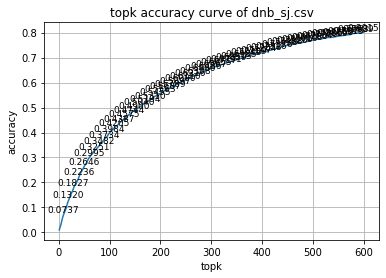

0.5228202840135373


In [9]:
topk = 600
distQR = euclidean_distances(ttX,trX)
distQR[distQR<0.001]=1e3
topk_precision = calc_topk_acc_cat_all(-distQR,ttY,trY.reshape(-1),k=topk)

x = list(range(1,topk+1))
y = list(topk_precision)
plt.figure()
plt.plot(x,y)

plt.grid()

for z in range(10,topk+1,10):
    z = z - 1
    plt.text(z, y[z], '%.4f' % y[z], ha='center', va= 'bottom',fontsize=9)

plt.xlabel("topk")
plt.ylabel("accuracy")
plt.title("topk accuracy curve of %s"%cfile[ind_city])
plt.show()


Y_tt_Y = np.tile(ttY,(1,trY.shape[0]))
Y_tr_Y = np.tile(trY.transpose(),(ttY.shape[0],1))

groundtruth = Y_tt_Y == Y_tr_Y
groundtruth = groundtruth + 0


fpr, tpr, roc_thresholds = roc_curve(groundtruth.reshape(-1),-distQR.reshape(-1))
roc_auc = auc(fpr,tpr)
print(roc_auc)

In [82]:
np.tile(ttY,(1,trY.shape[0])).shape

(1244, 6219)

In [48]:
trX.shape,ttX.shape,trY.shape,ttY.shape

((6219, 102), (1244, 102), (6219, 1), (1244, 1))

In [83]:
np.tile(trY,(1,trY.shape[0])).transpose().shape

(6219, 6219)

In [53]:
max_k_cat.shape

(1244, 100, 1)

,duns_number,groundtruth
0,2115256.0,37d0b499-fb84-a552-c17f-cbb1442d7895
1,2127360.0,7a687b49-1055-24f6-ae84-e390438fe3c4
2,2201159.0,d880cdef-04ae-7698-0499-5123172f6033
3,2534951.0,7982ff34-35e3-cc76-e15a-9416f4306f63
4,2570517.0,8485ae38-7a98-1d78-3f87-64e508151cd9


In [2]:
#function_base
def splitdat(dat,key_column=['duns_number'],right_colunm='atlas_location_uuid_tr',rate_tr=0.8):
    """
    split the <company,location> pair into training/testing dat
    """
    tr = dat.sample(frac=rate_tr)
    tt = pd.merge(dat,tr,on=key_column,how='left',suffixes=['','_tr'])
    tt = tt[tt[right_colunm].isnull()]
    tt = tt[list(tr.columns)]
    print('Train dat:', len(tr), 'Test dat:', len(tt))
    return tr,tt

#data process
def onehotdat(dat,key_column:list):
    dat[key_column] = dat[key_column].astype(str)
    dum_dat = pd.get_dummies(dat[key_column],dummy_na=True)
    return dum_dat

def split2num(emp_range:str):
    max_emp_val = emp_range.replace(' ','').split('-')
    if len(max_emp_val)<2:
        return 10
    else:
        return float(max_emp_val[1])
    
def max_col(dat,col,minval=1):
    dat[col] = dat[col].apply(lambda r:max(r,minval))

def comp_dat_process(dat):
    """
    pd -> company key,cont_feature,spec_feature,dum_feature
    """
    one_hot_col_name = ['major_industry_category','location_type','primary_sic_2_digit']
    spec_col_name = 'emp_here_range'
    cont_col_name = ['emp_here','emp_total','sales_volume_us','square_footage']

    print('doing one-hot...')
    dum_dat = onehotdat(dat,one_hot_col_name)
    
    print('extract continuous...')
    cont_dat = dat[cont_col_name].fillna(value=0).astype(float)
    
    print('specific feature')
    spec_dat = dat[spec_col_name].fillna(value='1-10').astype(str)
    spec_dat = spec_dat.apply(lambda row: split2num(row))
    
    max_col(cont_dat,'emp_here',1)
    
    res_dat = dat[['duns_number']].join([cont_dat,spec_dat,dum_dat],how='left')
    assert(len(res_dat)==len(dum_dat))
    assert(len(res_dat)==len(cont_dat))
    assert(len(res_dat)==len(spec_dat))
    return res_dat

def comp_transpd2np(featdat,trdat,ttdat,not_col_name):
    tr_feat = pd.merge(trdat,featdat,on='duns_number',how='inner')
#     print(col_list)
    col_list = [ n for n in list(tr_feat.columns) if n not in not_col_name ] 
    trainX = tr_feat.loc[:,col_list].to_numpy()
    trainY = tr_feat[['atlas_location_uuid','longitude_loc','latitude_loc']].to_numpy()
    
    tt_feat = pd.merge(ttdat,featdat,on='duns_number',how='inner')
    col_list = [ n for n in list(tt_feat.columns) if n not in not_col_name ] 
#     print(col_list)
    testX = tt_feat.loc[:,col_list].to_numpy()
    testY = tt_feat[['atlas_location_uuid','longitude_loc','latitude_loc']].to_numpy()
    return trainX,trainY,testX,testY

def normalize_dat(trX,ttX,cols=5,axis=0):
    D = trX[:,:cols]
    center = D.mean(axis=axis)
    center = np.expand_dims(center,axis)
    scale = D.std(axis=axis)
    scale = np.expand_dims(scale,axis)
    
    trX[:,:cols] = (D-center)/scale
    ttX[:,:cols] = (ttX[:,:cols]-center)/scale
    
def calc_topk_acc_v2(QRscore,y_truth_cat,R_cat,k=3):
    """
    QRscore: similarity score matrix shape [Q,R]
    y_truth: index(related with R) of truth label of Query
    """
    y_truth_cat = y_truth_cat.reshape(-1,1)
    max_k_preds = QRscore.argsort(axis=1)[:, -k:][:, ::-1] #得到top-k max label
    max_k_cat = R_cat[max_k_preds]
    match_array = np.logical_or.reduce(max_k_cat==y_truth_cat, axis=1) #得到匹配结果
    topk_acc_score = match_array.sum() / match_array.shape[0]
    return topk_acc_score

def calc_topk_acc_cat_all(QRscore,y_truth_cat,R_cat,k=3):
    """
    QRscore: similarity score matrix shape [Q,R]
    y_truth: index(related with R) of truth label of Query
    return top1-topk acc
    """
    res = []
    y_truth_cat = y_truth_cat.reshape(-1,1)
    max_k_preds = QRscore.argsort(axis=1)[:, -k:][:, ::-1] #得到top-k max label
    max_k_cat = R_cat[max_k_preds]
    M = max_k_cat==y_truth_cat
    for k in range(M.shape[1]):
        match_array = np.logical_or.reduce(M[:,:k+1], axis=1) #得到匹配结果
        topk_acc_score = match_array.sum() / match_array.shape[0]
        res.append(topk_acc_score)
    return res